<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Directions-and-Data-Loading" data-toc-modified-id="Directions-and-Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Directions and Data Loading</a></span></li><li><span><a href="#Helper-function:-Generate-3D-grid-points-in-y,-z,-x-order" data-toc-modified-id="Helper-function:-Generate-3D-grid-points-in-y,-z,-x-order-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper function: Generate 3D grid points in y, z, x order</a></span></li><li><span><a href="#SPD/HFM-3D-function:-Builds-anisotropic-metric-from-LVA" data-toc-modified-id="SPD/HFM-3D-function:-Builds-anisotropic-metric-from-LVA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SPD/HFM 3D function: Builds anisotropic metric from LVA</a></span></li><li><span><a href="#Example-usage-if-running-as-a-script-(AGD/Eikonal-installed):" data-toc-modified-id="Example-usage-if-running-as-a-script-(AGD/Eikonal-installed):-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Example usage if running as a script (AGD/Eikonal installed):</a></span></li><li><span><a href="#Extract-grid-coordinates-and-build-deepkriging-spd-features" data-toc-modified-id="Extract-grid-coordinates-and-build-deepkriging-spd-features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extract grid coordinates and build deepkriging spd features</a></span></li><li><span><a href="#Outer-5-Fold-Loop-for-DeepKriging-(Nested-CV)" data-toc-modified-id="Outer-5-Fold-Loop-for-DeepKriging-(Nested-CV)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Outer 5-Fold Loop for DeepKriging (Nested CV)</a></span></li><li><span><a href="#Combining-DeepKriging-+-LDM" data-toc-modified-id="Combining-DeepKriging-+-LDM-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Combining DeepKriging + LDM</a></span></li><li><span><a href="#Model-Comparisons:-OK-vs.-DeepKriging-vs.-Cond_DK" data-toc-modified-id="Model-Comparisons:-OK-vs.-DeepKriging-vs.-Cond_DK-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model Comparisons: OK vs. DeepKriging vs. Cond_DK</a></span></li><li><span><a href="#Compute-RMSE-for-Each-Method" data-toc-modified-id="Compute-RMSE-for-Each-Method-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Compute RMSE for Each Method</a></span></li><li><span><a href="#Visualization-Examples" data-toc-modified-id="Visualization-Examples-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Visualization Examples</a></span></li></ul></div>

## Imports

In [1]:
import os
import copy
import shutil
import sys
import glob
import time
import re

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Geostatistics, HFM, and other packages
import pygeostat as gs
from agd import Eikonal
from agd.Metrics import Riemann

from tqdm import tqdm
from scipy import spatial
from scipy.signal import remez, minimum_phase, freqz, group_delay
from scipy import io
from decimal import Decimal
from statsmodels.graphics import tsaplots
from sklearn.metrics import r2_score

# Neural network packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# For hyperparameter tuning
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split



## Directions and Data Loading


In [2]:
# Directories: specify your local directories here (update paths as needed)
exedir = 'exe/'
if not os.path.exists('LDM'):
    os.makedirs('LDM')
    
# Load the grid definition from a file (adjust filename as needed)
griddef = gs.GridDef(grid_file='./Data/griddef.txt')
print(griddef)

# Load borehole (or sample) data (adjust filename/columns as needed)
bhdata = gs.DataFile('./Data/cudata.dat', griddef=griddef, readfl=True)

# Example: Load an LVA (Local Varying Anisotropy) file
LVA = gs.DataFile('./Data/LVA.out', griddef=griddef)
LVA.addcoord()  # Add coordinate columns (X, Y, Z) if not present


# Rename columns for consistency
LVA.data = LVA.data.rename(columns={
    'angle1': 'strike',
    'angle2': 'dip',
    'angle3': 'plunge',
    'ranges12': 'r1',
    'ranges13': 'r2'
})

# Save an updated version
gs.write_gslib(LVA.data, './Data/LVA_coord.out')
LVA = gs.DataFile('./Data/LVA_coord.out', griddef=griddef)


# Clip very low r1/r2 values (avoid zero distances in LVA)
minval = 1e-3
LVA.data['r1'] = LVA.data['r1'].clip(lower=minval)
LVA.data['r2'] = LVA.data['r2'].clip(lower=minval)

LVA.data.describe()




125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0


,x,y,z,Cu,strike,dip,plunge,r1,r2
count,400000.000000,400000.00000,400000.000000,399773.000000,400000.000000,400000.000000,400000.0,400000.000000,400000.000000
mean,35337.500000,28000.00000,900.000000,0.211818,209.147485,-68.527296,0.0,1.721701,2.461558
std,541.249233,346.38353,173.151162,0.140507,49.457404,8.043843,0.0,0.537070,0.994471
min,34407.500000,27407.50000,607.500000,0.010372,0.000088,-89.999179,0.0,1.000567,1.033454
25%,34872.500000,27703.75000,753.750000,0.116053,183.222493,-72.781460,0.0,1.304971,1.671765
50%,35337.500000,28000.00000,900.000000,0.167660,196.947564,-66.076791,0.0,1.547392,2.085824
75%,35802.500000,28296.25000,1046.250000,0.273079,242.961914,-62.643701,0.0,2.013723,3.113983
max,36267.500000,28592.50000,1192.500000,1.470353,359.997907,-54.602578,0.0,2.819981,4.413696


## Helper function: Generate 3D grid points in y, z, x order


In [ ]:
def generate_grid_points_rev3D(griddef, order='GSLIB'):
    """
    Generate (y, z, x) coords for the FULL grid, shaped (nz, ny, nx)
    if you want that ordering. This is tailored to the HFM approach
    that uses y,z,x indexing.
    
    If order=='GSLIB', we flatten in 'C' order.
    """
    ny, nz, nx = griddef.ny, griddef.nz, griddef.nx
    
    # Build coordinate arrays
    y_vals = np.linspace(griddef.ylimits[0],
                         griddef.ylimits[1] - griddef.ysiz,
                         ny)
    z_vals = np.linspace(griddef.zlimits[0],
                         griddef.zlimits[1] - griddef.zsiz,
                         nz)
    x_vals = np.linspace(griddef.xlimits[0],
                         griddef.xlimits[1] - griddef.xsiz,
                         nx)
    
    # Y, Z, X => shape (ny, nz, nx) if indexing='ij'
    Y, Z, X = np.meshgrid(y_vals, z_vals, x_vals, indexing='ij')
    
    if order == 'GSLIB':
        coords = np.column_stack([Y.ravel(order='C'),
                                  Z.ravel(order='C'),
                                  X.ravel(order='C')])
    else:
        coords = np.column_stack([Y.ravel(order='F'),
                                  Z.ravel(order='F'),
                                  X.ravel(order='F')])
    return coords

# ----------------------------------------------------------------------
# Helper function: generate "landmark" points for the SPD approach
# ----------------------------------------------------------------------
def landmark_points_rev3D(Ly, Lz, Lx, griddef, plot=False):
    """
    3D extension for landmark points, specifically in (y,z,x) order.
    We interpret dims=[nz, ny, nx].
    """
    ny, nz, nx = griddef.ny, griddef.nz, griddef.nx
    
    # Determine intervals
    interval_y = ny/(Ly + 1)
    interval_z = nz/(Lz + 1)
    interval_x = nx/(Lx + 1)
    
    # Actual domain range
    y_vals = np.linspace(griddef.ylimits[0] + interval_y*griddef.ysiz,
                         griddef.ylimits[1] - interval_y*griddef.ysiz,
                         Ly)
    z_vals = np.linspace(griddef.zlimits[0] + interval_z*griddef.zsiz,
                         griddef.zlimits[1] - interval_z*griddef.zsiz,
                         Lz)
    x_vals = np.linspace(griddef.xlimits[0] + interval_x*griddef.xsiz,
                         griddef.xlimits[1] - interval_x*griddef.xsiz,
                         Lx)
    
    # Mesh in (y,z,x)
    Yv, Zv, Xv = np.meshgrid(y_vals, z_vals, x_vals, indexing='ij')
    
    if plot:
        # Quick debug plot
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(Yv, Zv, Xv, c='k')
        ax.set_title(f"Landmark Points: (Ly={Ly}, Lz={Lz}, Lx={Lx})")
        plt.show()
    
    return Yv, Zv, Xv

# ----------------------------------------------------------------------
# Helper function: angles => unit vector (strike, dip, plunge)
# ----------------------------------------------------------------------
def angles_to_unit_vector_3D(strike_deg, dip_deg, plunge_deg):
    """
    Convert (strike, dip, plunge) in degrees -> (uX, uY, uZ).
    For demonstration, ignoring plunge in the final formula.
    """
    s = np.radians(strike_deg)
    d = np.radians(dip_deg)
    # ignoring plunge for simplicity

    # Example formula for directions
    uX = np.sin(s) * np.cos(d)
    uY = np.cos(s) * np.cos(d)
    uZ = -np.sin(d)
    
    length = np.sqrt(uX**2 + uY**2 + uZ**2)
    if length > 1e-12:
        uX, uY, uZ = uX/length, uY/length, uZ/length
    return uX, uY, uZ

## SPD/HFM 3D function: Builds anisotropic metric from LVA


In [ ]:
def SPD_HFM_3D_rev10(hfmIn, LVA, griddef, N_data,
                     order='GSLIB', geodesics=False,
                     tips=(4,4,4), L_points=(10,10,10)):
    """
    3D version that uses (y,z,x) axis order and a Riemann3 model in Eikonal.
    """
    ny, nz, nx = griddef.ny, griddef.nz, griddef.nx
    
    # LVA columns
    if 'r1' not in LVA.data.columns or 'r2' not in LVA.data.columns:
        raise ValueError("LVA must have r1, r2 columns!")
    if 'strike' not in LVA.data.columns or 'dip' not in LVA.data.columns:
        raise ValueError("Need strike, dip columns!")
    
    # Safely clip
    LVA.data['r1'] = LVA.data['r1'].clip(lower=1e-3)
    LVA.data['r2'] = LVA.data['r2'].clip(lower=1e-3)
    
    strike_arr = LVA['strike'].values
    dip_arr    = LVA['dip'].values
    r1_arr     = LVA['r1'].values
    r2_arr     = LVA['r2'].values
    
    if len(strike_arr) != N_data:
        raise ValueError("Mismatch in LVA size vs N_data!")
    
    # Reshape to (nz, ny, nx) in row-major => 'C'
    strike_3d = strike_arr.reshape(nz, ny, nx, order='C')
    dip_3d    = dip_arr.reshape(nz, ny, nx, order='C')
    r1_3d     = r1_arr.reshape(nz, ny, nx, order='C')
    r2_3d     = r2_arr.reshape(nz, ny, nx, order='C')
    
    # Build orientation arrays
    uX_3d = np.zeros((nz, ny, nx), dtype=float)
    uY_3d = np.zeros((nz, ny, nx), dtype=float)
    uZ_3d = np.zeros((nz, ny, nx), dtype=float)
    
    # Convert angles => directional vectors
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                st_deg = strike_3d[k,j,i]
                dp_deg = dip_3d[k,j,i]
                ux, uy, uz = angles_to_unit_vector_3D(st_deg, dp_deg, 0.0)
                uX_3d[k,j,i] = ux
                uY_3d[k,j,i] = uy
                uZ_3d[k,j,i] = uz

    # alpha, beta => 1/r1, 1/r2
    alpha = 1.0 / r1_3d
    beta  = 1.0 / r2_3d
    
    # Build metric => Riemann.needle(...) => dual
    hfmIn['metric'] = Riemann.needle(
        (uX_3d, uY_3d, uZ_3d),
        alpha,
        beta
    ).dual()

    if geodesics:
        hfmIn.SetUniformTips(tips)
    hfmIn['exportValues'] = 1
    hfmIn['exportGeodesicFlow'] = 0
    
    path_vis = []
    
    # If L_points==0 => do NxN SPD
    if L_points == 0:
        coords_3d = generate_grid_points_rev3D(griddef, order=order)
        N_h_spd = N_data
        h_spd_mtx = np.zeros((N_data, N_data), dtype=np.float32)
        
        # NxN distances => watch memory if large
        N_pairs = int(N_data*(N_data-1)/2)
        h_spd_vecc = np.zeros((N_pairs,1), dtype=np.float32)
        i = 0
        for i1 in tqdm(range(N_h_spd-1)):
            sy, sz, sx = coords_3d[i1,:]
            hfmIn['seed'] = [sy, sz, sx]  # (y,z,x)
            hfmOut = hfmIn.Run()
            
            if geodesics:
                path_vis.append(hfmOut['geodesics'])
            
            if order=='GSLIB':
                dist_flat = hfmOut['values'].flatten(order='C')
            else:
                dist_flat = hfmOut['values'].flatten(order='F')
            
            i2_len = N_data - (i1+1)
            h_spd_vecc[i:i+i2_len,0] = dist_flat[i1+1:]
            h_spd_mtx[i1+1:, i1] = h_spd_vecc[i:i+i2_len,0]
            i += i2_len
        
        # Mirror
        h_spd_mtx = h_spd_mtx + h_spd_mtx.T
    else:
        # Landmark approach
        Ly, Lz, Lx = L_points
        Yv, Zv, Xv = landmark_points_rev3D(Ly, Lz, Lx, griddef, plot=False)
        
        if order=='GSLIB':
            source_y = Yv.flatten(order='C')
            source_z = Zv.flatten(order='C')
            source_x = Xv.flatten(order='C')
        else:
            source_y = Yv.flatten(order='F')
            source_z = Zv.flatten(order='F')
            source_x = Xv.flatten(order='F')
        
        N_h_spd = Ly*Lz*Lx
        h_spd_mtx = np.zeros((N_h_spd, N_data), dtype=np.float32)
        
        for i1 in tqdm(range(N_h_spd)):
            sy, sz, sx = source_y[i1], source_z[i1], source_x[i1]
            hfmIn['seed'] = [sy, sz, sx]
            hfmOut = hfmIn.Run()
            
            if geodesics:
                path_vis.append(hfmOut['geodesics'])
            
            if order=='GSLIB':
                dist_flat = hfmOut['values'].flatten(order='C')
            else:
                dist_flat = hfmOut['values'].flatten(order='F')
            
            h_spd_mtx[i1,:] = dist_flat
    
    return h_spd_mtx, path_vis


## Example usage if running as a script (AGD/Eikonal installed):


In [ ]:
if __name__ == "__main__":
    import pygeostat as gs

    # Prepare the HFM input dictionary
    hfmIn = Eikonal.dictIn({
        'arrayOrdering': 'RowMajor',  # row-major for y,z,x
        'model': 'Riemann3',         # 3D model
        'seedValue': 0,
        'geodesicStep': 0.1,
        'order': 5,
    })

    # Sides => (y-limits, z-limits, x-limits), dims => [nz, ny, nx]
    hfmIn.SetRect(
        sides=[
            [griddef.ylimits[0], griddef.ylimits[1]],
            [griddef.zlimits[0], griddef.zlimits[1]],
            [griddef.xlimits[0], griddef.xlimits[1]]
        ],
        dims=[griddef.nz, griddef.ny, griddef.nx]
    )
    
    # Example: SPD matrix from landmark approach
    N_data = griddef.count()  # total cells
    h_spd_mtx, path_vis = SPD_HFM_3D_rev10(
        hfmIn, LVA, griddef,
        N_data=N_data,
        order='GSLIB',
        geodesics=True,
        tips=(4,4,4),
        L_points=(5,5,5)  # landmark points
    )
    print("SPD shape:", h_spd_mtx.shape)
    print("Number of geodesic paths:", len(path_vis))


## Extract grid coordinates and build deepkriging spd features

In [ ]:
x, y, z = griddef.get_coordinates()
grid_coords = np.hstack((
    x.reshape(len(x),1),
    y.reshape(len(y),1),
    z.reshape(len(z),1)
))

import numpy as np
import pandas as pd
from scipy import spatial
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hyperopt
from hyperopt import fmin, tpe, hp, Trials

# Suppose h_spd_mtx is the SPD matrix from the code above (landmark approach).
# Standardize SPD values:
mean_value = np.mean(h_spd_mtx)
std_value = np.std(h_spd_mtx)
h_spd_HFM_scaled = (h_spd_mtx - mean_value) / (std_value + 1e-12)

# Create a DataFrame for grid coordinates if needed
df1 = pd.DataFrame(grid_coords, columns=['X', 'Y', 'Z'])

# Optionally, normalize these coords
lon = df1['X'].values
lat = df1['Y'].values
elev = df1['Z'].values

normalized_lon = (lon - lon.min()) / (lon.max() - lon.min())
normalized_lat = (lat - lat.min()) / (lat.max() - lat.min())
normalized_elev = (elev - elev.min()) / (elev.max() - elev.min())

s_test = np.vstack((normalized_lon, normalized_lat, normalized_elev)).T

## Outer 5-Fold Loop for DeepKriging (Nested CV)

In [ ]:
for fold in range(1, 6):
    print(f"\n========================")
    print(f" OUTER FOLD {fold}/5")
    print(f"========================\n")

    # Load outer-train data
    Traindat = gs.DataFile(f'./Data/Training0{fold}.dat', x='X', y='Y', z='Z')
    df_train = Traindat.data

    # Find nearest grid node to each training point
    near_points = df1[['X','Y','Z']].values
    tree = spatial.KDTree(near_points)
    idx = tree.query(df_train[['X','Y','Z']].values)[1]

    # Group by neighbor index to get average 'Cu' per grid cell
    df_train_neighbor = df_train.assign(neighbor=idx)
    df_cu = df_train_neighbor.groupby('neighbor')['Cu'].mean()

    idx_new = df_cu.index.values
    pm25 = df_cu.values

    # SPD features => shape (#gridcells, #landmarks)
    phi_combined = h_spd_HFM_scaled.T  # transpose => (N, #landmarks)
    # Subset to training points
    X_full = phi_combined[idx_new, :]
    y_full = pm25.reshape(-1,1)

    # Model-building function
    def create_model(hparams, input_dim):
        """
        Build a Keras MLP using hyperparameters.
        """
        model = Sequential()
        # 3 hidden layers
        model.add(Dense(
            int(hparams['units']),
            input_dim=input_dim,
            kernel_initializer='he_uniform',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-6, l2=1e-4)
        ))
        model.add(Dropout(hparams['dropout']))

        model.add(Dense(
            int(hparams['units']),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-6, l2=1e-4)
        ))
        model.add(Dropout(hparams['dropout']))

        model.add(Dense(
            int(hparams['units']),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-6, l2=1e-4)
        ))
        model.add(Dropout(hparams['dropout']))

        # Output layer
        model.add(Dense(1, activation='linear'))

        optimizer = Adam(learning_rate=hparams['learning_rate'])
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    # Hyperopt objective function
    def hyperopt_objective(hparams):
        """
        K-Fold CV on (X_full, y_full). Return average MSE to minimize.
        """
        epochs = int(hparams['epochs'])
        batch_size = int(hparams['batch_size'])
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42 + fold)
        fold_mses = []
        for train_index, val_index in kf.split(X_full):
            X_tr, X_val = X_full[train_index], X_full[val_index]
            y_tr, y_val = y_full[train_index], y_full[val_index]

            model = create_model(hparams, input_dim=X_full.shape[1])
            model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)

            y_val_pred = model.predict(X_val)
            fold_mses.append(mean_squared_error(y_val, y_val_pred))

        return np.mean(fold_mses)

    # Define Hyperparameter search space
    search_space = {
        'units': hp.quniform('units', 600, 900, 300),
        'dropout': hp.uniform('dropout', 0.2, 0.5),
        'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-4)),
        'epochs': hp.quniform('epochs', 600, 1000, 200),
        'batch_size': hp.quniform('batch_size', 64, 256, 32),
    }

    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(
        fn=hyperopt_objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=5,  # small example, you may want to increase!
        rstate=np.random.default_rng(42 + fold)
    )

    # Convert hyperparams to integers where needed
    best['units'] = int(best['units'])
    best['epochs'] = int(best['epochs'])
    best['batch_size'] = int(best['batch_size'])

    print("Best hyperparameters from inner CV:")
    print(best)

    # Retrain final model on full outer-train
    def create_regularized_model_final(best_params, input_dim):
        model = Sequential()
        # 3 hidden layers
        for _ in range(3):
            model.add(Dense(
                best_params['units'],
                input_dim=input_dim,
                kernel_initializer='he_uniform',
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-6, l2=1e-4)
            ))
            model.add(Dropout(best_params['dropout']))
            # only set input_dim on first layer
            input_dim = None

        model.add(Dense(1, activation='linear'))

        optimizer = Adam(learning_rate=best_params['learning_rate'])
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    final_model = create_regularized_model_final(best, input_dim=X_full.shape[1])
    final_model.fit(X_full, y_full, epochs=best['epochs'], batch_size=best['batch_size'], verbose=0)

    # Predict on entire domain
    X_RBF_pred = phi_combined  # (N, #landmarks)
    PM25_pred = final_model.predict(X_RBF_pred)

    PM25_pred[PM25_pred < 0] = 0  # optional clipping

    outfile = f'DeepKriging_{fold}.out'
    gs.write_gslib(pd.DataFrame(PM25_pred), outfile)
    print(f"Domain predictions saved: {outfile}")

    # Evaluate on validation
    testfile = gs.DataFile(flname=f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)
    DeepKriging = gs.DataFile(outfile, griddef=griddef)

    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]

    # Compute R^2
    r2_val = r2_score(testfile['Cu'], DeepKriging.data['0'][idx].values)


## Combining DeepKriging + LDM

In [20]:
for fold in range(1,6):
    deepkriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)
    moment = gs.DataFile(f'./IDW/Debug_{fold}.out', x='APX', y='APY')  # local means
    
    # Weighted combination
    moment.data['Variance'] = moment.data['Local std.dev.']**2
    moment.data['Scaled_Variance'] = (
        moment.data['Variance'] - moment.data['Variance'].min()
    ) / (
        moment.data['Variance'].max() - moment.data['Variance'].min()
    )
    weight = moment['Scaled_Variance'] ** 0.25

    cond_DK = deepkriging['0'] * np.array(weight) + moment['Local Mean'] * (1 - np.array(weight))

    # Save conditional DK
    gs.write_gslib(pd.DataFrame(cond_DK), f'./IDW/Weighted_DK_{fold}.out')


## Model Comparisons: OK vs. DeepKriging vs. Cond_DK

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

OK_R2 = 0
DeepKriging_R2 = 0
Cond_DK_R2 = 0
OK_Ensemble = 0
DeepKriging_Ensemble = 0
Cond_DK_Ensemble = 0

for fold in range(1, 6):
    testfile = gs.DataFile(flname=f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)

    OK = gs.DataFile(f'OK_{fold}.out', griddef=griddef)  # from external kriging
    OK.data.loc[OK.data['Estimate'] < 0, 'Estimate'] = 0

    Cond_DK = gs.DataFile(f'./IDW/Weighted_DK_{fold}.out', griddef=griddef)

    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]

    
    OK_R2 += r2_score(testfile['Cu'], OK.data['Estimate'][idx].values)
    Cond_DK_R2 += r2_score(testfile['Cu'], Cond_DK.data['0'][idx].values)

    OK_Ensemble += OK.data['Estimate'].values.reshape(-1, 1)
    Cond_DK_Ensemble += Cond_DK.data['0'].values.reshape(-1, 1)

OK_Performance = round(OK_R2/5, 2)
DeepKriging_Performance = round(DeepKriging_R2/5, 2)
Cond_DK_Performance = round(Cond_DK_R2/5, 2)
print("Avg R² => OK:", OK_Performance,
      "Cond DK:", Cond_DK_Performance)

OK_Avg = OK_Ensemble / 5
DeepKriging_Avg = DeepKriging_Ensemble / 5
Cond_DK_Avg = Cond_DK_Ensemble / 5

gs.write_gslib(pd.DataFrame(OK_Avg), 'OK_Average.out')
gs.write_gslib(pd.DataFrame(Cond_DK_Avg), 'Cond_DK_Average.out')

Avg R² => OK: 0.67 Cond DK: 0.68


## Compute RMSE for Each Method

In [22]:
from sklearn.metrics import mean_squared_error

OK_RMSE = 0
DeepKriging_RMSE = 0
Cond_DK_RMSE = 0

for fold in range(1, 6):
    testfile = gs.DataFile(f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)
    
    OK = gs.DataFile(f'OK_{fold}.out', griddef=griddef)
    OK.data.loc[OK.data['Estimate'] < 0, 'Estimate'] = 0
    
    DeepKriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)
    Cond_DK = gs.DataFile(f'./IDW/Weighted_DK_{fold}.out', griddef=griddef)
    
    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]
    
    OK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], OK.data['Estimate'][idx].values))
    DeepKriging_rmse = np.sqrt(mean_squared_error(testfile['Cu'], DeepKriging.data['0'][idx].values))
    Cond_DK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], Cond_DK.data['0'][idx].values))

    OK_RMSE += OK_rmse
    DeepKriging_RMSE += DeepKriging_rmse
    Cond_DK_RMSE += Cond_DK_rmse

print("Avg RMSE =>",
      "OK:", round(OK_RMSE/5,3),
      "DeepKriging:", round(DeepKriging_RMSE/5,3),
      "Cond_DK:", round(Cond_DK_RMSE/5,3))


Avg RMSE => OK: 0.135 DeepKriging: 0.144 Cond_DK: 0.134


## Visualization Examples

In [23]:
Cond_DK_results = gs.DataFile('Cond_DK_Average.out')

C:\Users\erdogane\AppData\Local\Temp\ipykernel_24568\2406851097.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=3, w_pad=1.5)


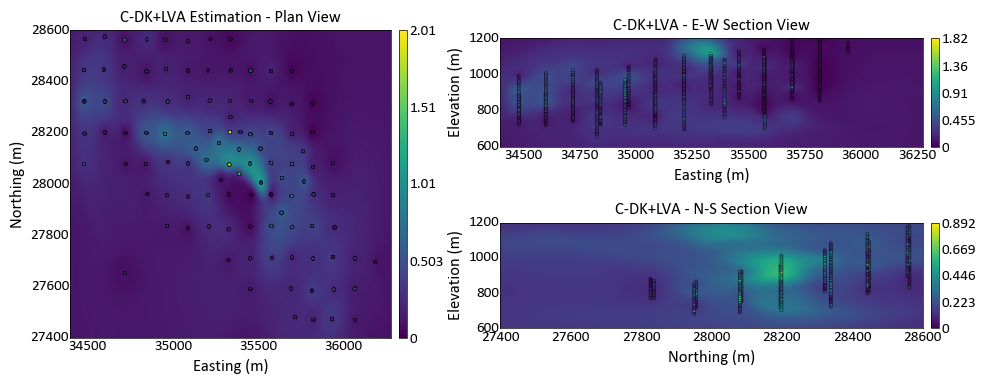

In [28]:
# Slice plots for Cond_DK
from matplotlib import gridspec

fig1 = plt.figure(figsize=(10, 4))
gs2 = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])

# Plan view
gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='C-DK+LVA Estimation - Plan View', ax=ax0,
    slice_number=20, aspect=1.5
)

# E-W Section
gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='C-DK+LVA - E-W Section View', ax=ax1,
    slice_number=60, aspect=0.8, orient='xz'
)

# N-S Section
gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='C-DK+LVA - N-S Section View', ax=ax2,
    slice_number=40, aspect=0.5, orient='yz'
)

plt.tight_layout(h_pad=3, w_pad=1.5)
plt.savefig("Figure13c.png", dpi=300, bbox_inches='tight')

plt.show()


In [25]:
# ======================================================================
# Print out versions for debugging
# ======================================================================
import sys
import platform
import tqdm
import scipy
import statsmodels
import sklearn
import hyperopt

print("System platform:", platform.platform())
print("Python version :", sys.version)
print("NumPy version  :", np.__version__)
print("Pandas version :", pd.__version__)
print("Matplotlib version  :", mpl.__version__)
print("Seaborn version     :", sns.__version__)
print("pygeostat version   :", getattr(gs, '__version__', 'No version attribute'))
print("tqdm version        :", tqdm.__version__)
print("SciPy version       :", scipy.__version__)
print("statsmodels version :", statsmodels.__version__)
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version  :", tf.__version__)
print("hyperopt version    :", hyperopt.__version__)
# If AGD/Eikonal has a version attribute:
# from agd import Eikonal
# print("AGD/Eikonal version:", getattr(Eikonal, '__version__', 'No version attribute'))

System platform: Windows-10-10.0.22631-SP0
Python version : 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
NumPy version  : 2.0.1
Pandas version : 2.2.3
Matplotlib version  : 3.10.0
Seaborn version     : 0.13.2
pygeostat version   : 1.1.1
tqdm version        : 4.67.1
SciPy version       : 1.14.1
statsmodels version : 0.14.4
scikit-learn version: 1.6.0
TensorFlow version  : 2.18.0
hyperopt version    : 0.2.7
